In [1]:
from dotenv import load_dotenv
from langchain_cohere import ChatCohere

load_dotenv()

llm = ChatCohere(model="command-r-plus")


In [ ]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [2]:
from langchain_core.messages import HumanMessage, ToolMessage


def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {
        "messages": [HumanMessage(content=result["messages"][-1].content, name=name)]
    }

In [3]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.tools import tool


expert_prompt_template = ChatPromptTemplate.from_messages(
    [("system", "{system_prompt}"), ("user", "{user_prompt}")]
)
expert_chain = expert_prompt_template | llm | StrOutputParser()



In [4]:
import functools
import operator
from typing import Sequence, Annotated
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage

from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import create_react_agent

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from pydantic import BaseModel
from typing import Literal


# add "legal consultant"
#expert_system_prompts = {
#    "technical assistant": "You are an expert in technical issues and help with coding or technical problem solving.",
#    "financial advisor": "You provide advice and insights on financial matters, including budgeting, investment, and expenses.", 
#    "health expert": "You offer guidance on health, nutrition, and fitness-related topics.", 
#    "mental health guide": "You offer guidance on mental health, and psychology-related topics.", 
#    "travel guide": "You provide travel tips, itinerary suggestions, and destination recommendations."
#}

@tool
def generate_technical_response(user_prompt: str) -> str:
    """Generates response
    
    Args:
        inp: str
    Returns:
        str
    """
    prompt = {"system_prompt": "You are an expert in technical issues and help with coding or technical problem solving.", "user_prompt": user_prompt}
    response = expert_chain.invoke(prompt)
    return response

@tool
def generate_financial_response(user_prompt: str) -> str:
    """Generates response
    
    Args:
        inp: str
    Returns:
        str
    """
    prompt = {"system_prompt": "You provide advice and insights on financial matters, including budgeting, investment, and expenses.", "user_prompt": user_prompt}
    response = expert_chain.invoke(prompt)
    return response

@tool
def generate_health_response(user_prompt: str) -> str:
    """Generates response
    
    Args:
        inp: str
    Returns:
        str
    """
    prompt = {"system_prompt": "You offer guidance on health, nutrition, and fitness-related topics.", "user_prompt": user_prompt}
    response = expert_chain.invoke(prompt)
    return response

@tool
def generate_mental_health_response(user_prompt: str) -> str:
    """Generates response
    
    Args:
        inp: str
    Returns:
        str
    """
    prompt = {"system_prompt": "You offer guidance on mental health, and psychology-related topics.", "user_prompt": user_prompt}
    response = expert_chain.invoke(prompt)
    return response

@tool
def generate_travel_response(user_prompt: str) -> str:
    """Generates response
    
    Args:
        inp: str
    Returns:
        str
    """
    prompt = {"system_prompt": "You provide travel tips, itinerary suggestions, and destination recommendations.", "user_prompt": user_prompt}
    response = expert_chain.invoke(prompt)
    return response
    

# add "legal consultant"
members = ["Technical Assistant", "Financial Advisor", "Health Expert", "Mental Health Guide", "Travel Guide"]
system_prompt = (
    "You are a supervisor tasked with passing the user question/requests to the relevant experts."
    " The experts are: {members}. Given the following user request,"
    " respond with the expert to act next. The chosen expert should "
    " respond with its results. Once you got a response from the expert, "
    " respond with FINISH."
)
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = ["FINISH"] + members


class routeResponse(BaseModel):
    next: Literal[*options]


prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "user",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))


def supervisor_agent(state):
    supervisor_chain = prompt | llm.with_structured_output(routeResponse)
    response = supervisor_chain.invoke(state)
    return response


# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always
    # be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str


technical_agent = create_react_agent(llm, tools=[generate_technical_response])
technical_node = functools.partial(agent_node, agent=technical_agent, name="Technical Assistant")

financial_agent = create_react_agent(llm, tools=[generate_financial_response])
financial_node = functools.partial(agent_node, agent=financial_agent, name="Financial Advisor")

health_agent = create_react_agent(llm, tools=[generate_health_response])
health_node = functools.partial(agent_node, agent=health_agent, name="Health Expert")

mental_health_agent = create_react_agent(llm, tools=[generate_mental_health_response])
mental_health_node = functools.partial(agent_node, agent=mental_health_agent, name="Mental Health Guide")

travel_agent = create_react_agent(llm, tools=[generate_travel_response])
travel_node = functools.partial(agent_node, agent=travel_agent, name="Travel Guide")


workflow = StateGraph(AgentState)
workflow.add_node("Technical Assistant", technical_node)
workflow.add_node("Financial Advisor", financial_node)
workflow.add_node("Health Expert", health_node)
workflow.add_node("Mental Health Guide", mental_health_node)
workflow.add_node("Travel Guide", travel_node)
workflow.add_node("supervisor", supervisor_agent)


In [5]:
for member in members:
    workflow.add_edge(member, "supervisor")
# The supervisor populates the "next" field in the graph state
# which routes to a node or finishes
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)
# Finally, add entrypoint
workflow.add_edge(START, "supervisor")

graph = workflow.compile(checkpointer=memory)

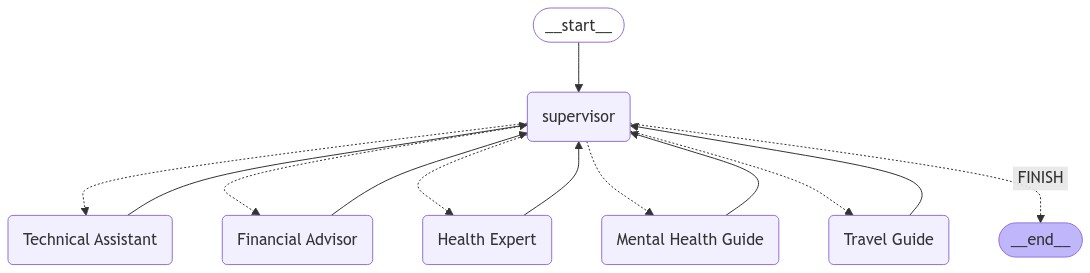

In [6]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
while True:
    user_input = input("USER: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break

    events = graph.stream(
        {"messages": [("user", user_input)]}
    )
    print("\n")
    for event in events:
        if 'supervisor' in event and event['supervisor']:
            if event['supervisor']['next'] == "FINISH":
                print('-'*100)
            else:
                print(f"{event['supervisor']['next'].upper()}: ", end="")
        else:
            for agent_name, agent_data in event.items():
                if not agent_data:
                    print("Something went wrong.")
                    break
                for message in agent_data["messages"]:
                    print(f"{message.content}\n")

USER:  i feel depressed




MENTAL HEALTH GUIDE: I'm sorry to hear that you're feeling depressed. Depression is a serious mental health condition that can affect anyone. It's important to remember that you are not alone in this and that help is available. Here are some steps you can take to start feeling better:

**Reach out for support:** Talking to someone about how you're feeling can be a great first step towards feeling better. Consider confiding in a trusted friend or family member, or seek support from a mental health professional.

**Practice self-care:** Taking care of yourself is crucial when you're dealing with depression. Make sure to get regular exercise, eat healthy meals, and get enough sleep. Also, try to engage in activities that you enjoy and find relaxing.

**Challenge negative thinking:** Depression often involves negative thoughts and beliefs about yourself and the world around you. Try to identify and challenge these negative thoughts. For example, if you find yourself thinking, "I'm a fail